# SSA on Real Data & Non-Sinusoidal Signals

Testing SSA on:
1. **Real stock data** (via yfinance)
2. **Non-sinusoidal synthetic signals** (square waves, sawtooth, ECG-like, etc.)

In [6]:
# Install yfinance if needed
# !pip install yfinance

import numpy as np
import matplotlib.pyplot as plt
from ssa_wrapper import SSA, MSSA

plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['font.size'] = 11
np.random.seed(42)

def rmse(a, b):
    return np.sqrt(np.mean((a - b)**2))

print("Ready!")

import sys
print(sys.executable)

Ready!
C:\Python313\python.exe


---
## Part 1: Real Stock Data

Fetch actual market data and analyze with SSA.

In [7]:
import yfinance as yf

# Fetch 2 years of daily data for several tickers
tickers = ['SPY', 'AAPL', 'NVDA', 'BTC-USD']
data = {}

for ticker in tickers:
    df = yf.download(ticker, period='2y', interval='1d', progress=False)
    data[ticker] = df['Close'].values
    print(f"{ticker}: {len(data[ticker])} days")

C:\Users\Tugbars\AppData\Local\Temp\ipykernel_44064\133665853.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period='2y', interval='1d', progress=False)


SPY: 501 days


C:\Users\Tugbars\AppData\Local\Temp\ipykernel_44064\133665853.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period='2y', interval='1d', progress=False)


AAPL: 501 days


C:\Users\Tugbars\AppData\Local\Temp\ipykernel_44064\133665853.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period='2y', interval='1d', progress=False)


NVDA: 501 days
BTC-USD: 732 days


C:\Users\Tugbars\AppData\Local\Temp\ipykernel_44064\133665853.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period='2y', interval='1d', progress=False)


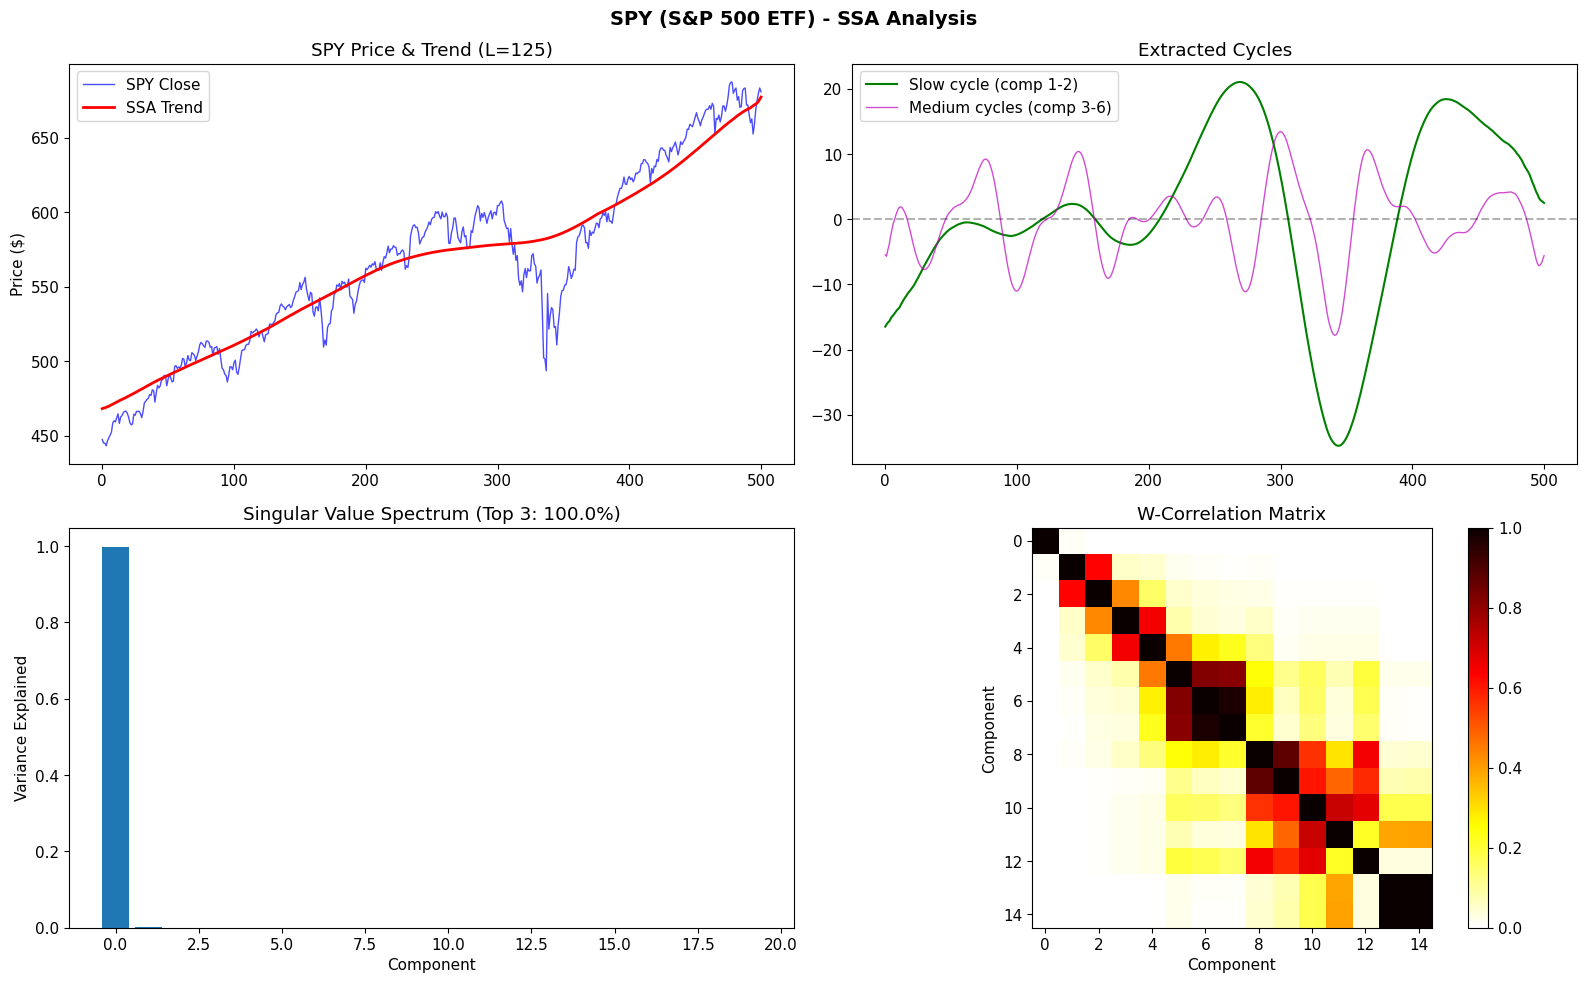

In [8]:
# Analyze SPY (S&P 500 ETF)
spy = data['SPY']
N = len(spy)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# SSA decomposition
L = N // 4  # ~125 days window
ssa = SSA(spy, L=L)
ssa.decompose(k=30)

# Extract components
trend = ssa.reconstruct([0])
slow_cycle = ssa.reconstruct([1, 2])  # ~quarterly cycle
medium_cycle = ssa.reconstruct([3, 4, 5, 6])  # monthly cycles
residual = spy - trend - slow_cycle - medium_cycle

# Plot 1: Price + Trend
ax = axes[0, 0]
ax.plot(spy, 'b-', lw=1, alpha=0.7, label='SPY Close')
ax.plot(trend, 'r-', lw=2, label='SSA Trend')
ax.set_title(f'SPY Price & Trend (L={L})')
ax.legend()
ax.set_ylabel('Price ($)')

# Plot 2: Decomposition
ax = axes[0, 1]
ax.plot(slow_cycle, 'g-', lw=1.5, label='Slow cycle (comp 1-2)')
ax.plot(medium_cycle, 'm-', lw=1, alpha=0.7, label='Medium cycles (comp 3-6)')
ax.axhline(0, color='k', ls='--', alpha=0.3)
ax.set_title('Extracted Cycles')
ax.legend()

# Plot 3: Variance spectrum
ax = axes[1, 0]
var_exp = [ssa.variance_explained(i, i) for i in range(20)]
ax.bar(range(20), var_exp)
ax.set_xlabel('Component')
ax.set_ylabel('Variance Explained')
ax.set_title(f'Singular Value Spectrum (Top 3: {sum(var_exp[:3]):.1%})')

# Plot 4: W-correlation
ax = axes[1, 1]
wcorr = ssa.wcorr_matrix()
im = ax.imshow(np.abs(wcorr[:15, :15]), cmap='hot_r', vmin=0, vmax=1)
ax.set_title('W-Correlation Matrix')
ax.set_xlabel('Component')
ax.set_ylabel('Component')
plt.colorbar(im, ax=ax)

plt.suptitle('SPY (S&P 500 ETF) - SSA Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

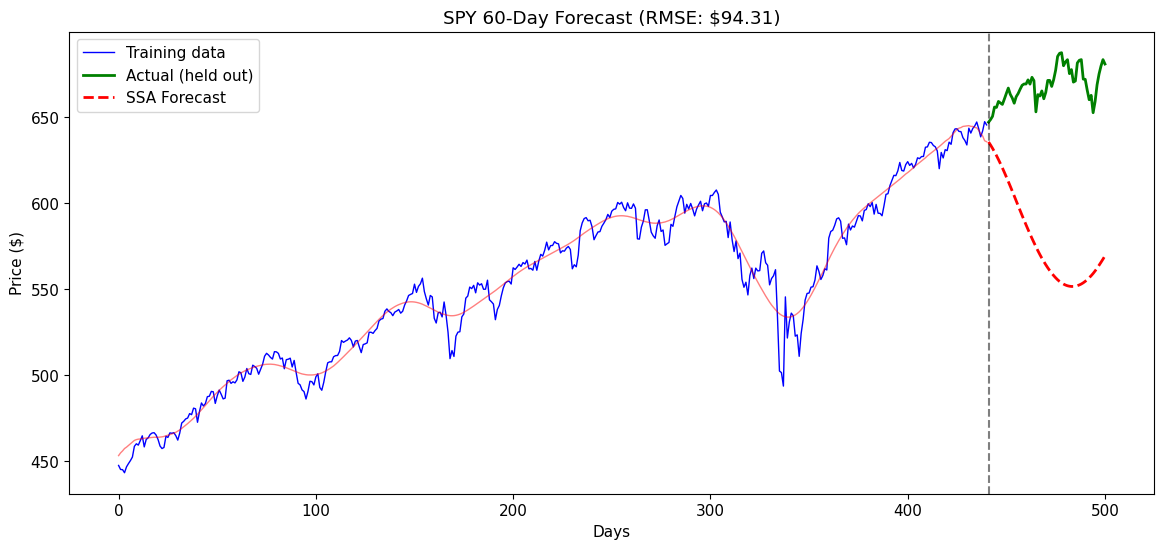

Forecast RMSE: $94.31
Forecast MAPE: 13.42%


In [4]:
# Forecasting on real data
N_train = len(spy) - 60  # Hold out last 60 days
spy_train = spy[:N_train]
spy_test = spy[N_train:]

ssa = SSA(spy_train, L=N_train//4)
ssa.decompose(k=20)

# Forecast using trend + first few cycles
forecast = ssa.forecast([0, 1, 2, 3, 4], n_forecast=60)
reconstruction = ssa.reconstruct([0, 1, 2, 3, 4])

fig, ax = plt.subplots(figsize=(14, 6))

t_train = np.arange(N_train)
t_test = np.arange(N_train, len(spy))

ax.plot(t_train, spy_train, 'b-', lw=1, label='Training data')
ax.plot(t_test, spy_test, 'g-', lw=2, label='Actual (held out)')
ax.plot(t_train, reconstruction, 'r-', lw=1, alpha=0.5)
ax.plot(t_test, forecast, 'r--', lw=2, label='SSA Forecast')
ax.axvline(N_train, color='k', ls='--', alpha=0.5)

fc_rmse = rmse(spy_test, forecast)
ax.set_title(f'SPY 60-Day Forecast (RMSE: ${fc_rmse:.2f})')
ax.legend()
ax.set_xlabel('Days')
ax.set_ylabel('Price ($)')
plt.show()

print(f"Forecast RMSE: ${fc_rmse:.2f}")
print(f"Forecast MAPE: {np.mean(np.abs(spy_test - forecast) / spy_test) * 100:.2f}%")

In [9]:
# MSSA on multiple stocks - find common market factor
# Align lengths
min_len = min(len(data[t]) for t in tickers)
X = np.array([data[t][-min_len:] for t in tickers])

# Normalize each series (z-score)
X_norm = (X - X.mean(axis=1, keepdims=True)) / X.std(axis=1, keepdims=True)

mssa = MSSA(X_norm, L=min_len//5)
mssa.decompose(k=15)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Original normalized series
ax = axes[0, 0]
for i, ticker in enumerate(tickers):
    ax.plot(X_norm[i], lw=1, alpha=0.7, label=ticker)
ax.set_title('Normalized Price Series')
ax.legend()

# Common factor
common = mssa.reconstruct_all([0])
ax = axes[0, 1]
for i, ticker in enumerate(tickers):
    ax.plot(common[i], lw=1.5, label=f'{ticker} common')
ax.set_title('Extracted Common Factor (Component 0)')
ax.legend()

# Series contributions
contrib = mssa.series_contributions()
ax = axes[1, 0]
im = ax.imshow(contrib[:, :10], aspect='auto', cmap='Blues')
ax.set_yticks(range(len(tickers)))
ax.set_yticklabels(tickers)
ax.set_xlabel('Component')
ax.set_title('Series Contributions')
plt.colorbar(im, ax=ax)

# Residual correlations
residuals = X_norm - common
corr = np.corrcoef(residuals)
ax = axes[1, 1]
im = ax.imshow(corr, cmap='RdBu_r', vmin=-1, vmax=1)
ax.set_xticks(range(len(tickers)))
ax.set_yticks(range(len(tickers)))
ax.set_xticklabels(tickers)
ax.set_yticklabels(tickers)
for i in range(len(tickers)):
    for j in range(len(tickers)):
        ax.text(j, i, f'{corr[i,j]:.2f}', ha='center', va='center')
ax.set_title('Residual Correlations')
plt.colorbar(im, ax=ax)

plt.suptitle('MSSA: Multi-Asset Common Factor Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

ValueError: X must be 2D array of shape (M, N)

---
## Part 2: Non-Sinusoidal Synthetic Signals

Testing SSA on signals that don't look like sine waves.

In [ ]:
from scipy import signal as sig

N = 1000
t = np.linspace(0, 10, N)

fig, axes = plt.subplots(3, 3, figsize=(16, 12))

# 1. Square wave
square_clean = sig.square(2*np.pi*t)
square_noisy = square_clean + 0.3*np.random.randn(N)

ssa = SSA(square_noisy, L=150)
ssa.decompose(k=30)
square_recon = ssa.reconstruct(list(range(15)))

ax = axes[0, 0]
ax.plot(t, square_clean, 'g-', lw=2, alpha=0.5, label='Clean')
ax.plot(t, square_noisy, 'b-', lw=0.3, alpha=0.3)
ax.plot(t, square_recon, 'r-', lw=1.5, label='SSA')
ax.set_title(f'Square Wave\nRMSE: {rmse(square_clean, square_recon):.3f}')
ax.legend()
ax.set_xlim([0, 3])

# 2. Sawtooth wave
sawtooth_clean = sig.sawtooth(2*np.pi*t)
sawtooth_noisy = sawtooth_clean + 0.3*np.random.randn(N)

ssa = SSA(sawtooth_noisy, L=150)
ssa.decompose(k=30)
sawtooth_recon = ssa.reconstruct(list(range(15)))

ax = axes[0, 1]
ax.plot(t, sawtooth_clean, 'g-', lw=2, alpha=0.5, label='Clean')
ax.plot(t, sawtooth_noisy, 'b-', lw=0.3, alpha=0.3)
ax.plot(t, sawtooth_recon, 'r-', lw=1.5, label='SSA')
ax.set_title(f'Sawtooth Wave\nRMSE: {rmse(sawtooth_clean, sawtooth_recon):.3f}')
ax.legend()
ax.set_xlim([0, 3])

# 3. Triangle wave
triangle_clean = sig.sawtooth(2*np.pi*t, width=0.5)
triangle_noisy = triangle_clean + 0.3*np.random.randn(N)

ssa = SSA(triangle_noisy, L=150)
ssa.decompose(k=25)
triangle_recon = ssa.reconstruct(list(range(12)))

ax = axes[0, 2]
ax.plot(t, triangle_clean, 'g-', lw=2, alpha=0.5, label='Clean')
ax.plot(t, triangle_noisy, 'b-', lw=0.3, alpha=0.3)
ax.plot(t, triangle_recon, 'r-', lw=1.5, label='SSA')
ax.set_title(f'Triangle Wave\nRMSE: {rmse(triangle_clean, triangle_recon):.3f}')
ax.legend()
ax.set_xlim([0, 3])

# 4. ECG-like signal
def make_ecg(t, heart_rate=1.0):
    """Simplified ECG-like waveform."""
    ecg = np.zeros_like(t)
    period = 1 / heart_rate
    for i, ti in enumerate(t):
        phase = (ti % period) / period
        if 0.0 < phase < 0.05:  # P wave
            ecg[i] = 0.2 * np.sin(phase / 0.05 * np.pi)
        elif 0.15 < phase < 0.17:  # Q
            ecg[i] = -0.1 * np.sin((phase - 0.15) / 0.02 * np.pi)
        elif 0.17 < phase < 0.22:  # R peak
            ecg[i] = 1.0 * np.sin((phase - 0.17) / 0.05 * np.pi)
        elif 0.22 < phase < 0.25:  # S
            ecg[i] = -0.2 * np.sin((phase - 0.22) / 0.03 * np.pi)
        elif 0.30 < phase < 0.45:  # T wave
            ecg[i] = 0.3 * np.sin((phase - 0.30) / 0.15 * np.pi)
    return ecg

ecg_clean = make_ecg(t, heart_rate=1.2)
ecg_noisy = ecg_clean + 0.1*np.random.randn(N)

ssa = SSA(ecg_noisy, L=120)
ssa.decompose(k=30)
ecg_recon = ssa.reconstruct(list(range(15)))

ax = axes[1, 0]
ax.plot(t, ecg_clean, 'g-', lw=2, alpha=0.5, label='Clean')
ax.plot(t, ecg_noisy, 'b-', lw=0.3, alpha=0.3)
ax.plot(t, ecg_recon, 'r-', lw=1.5, label='SSA')
ax.set_title(f'ECG-like Signal\nRMSE: {rmse(ecg_clean, ecg_recon):.3f}')
ax.legend()
ax.set_xlim([0, 5])

# 5. Step function with ramps
steps_clean = np.zeros(N)
levels = [0, 1, 0.5, 2, 1, 0]
step_size = N // len(levels)
for i, level in enumerate(levels):
    start = i * step_size
    end = min((i + 1) * step_size, N)
    if i < len(levels) - 1:
        # Ramp transition
        ramp_len = step_size // 5
        steps_clean[start:start+ramp_len] = np.linspace(levels[i-1] if i > 0 else 0, level, ramp_len)
        steps_clean[start+ramp_len:end] = level
    else:
        steps_clean[start:end] = level
steps_noisy = steps_clean + 0.2*np.random.randn(N)

ssa = SSA(steps_noisy, L=100)
ssa.decompose(k=20)
steps_recon = ssa.reconstruct(list(range(8)))

ax = axes[1, 1]
ax.plot(t, steps_clean, 'g-', lw=2, alpha=0.5, label='Clean')
ax.plot(t, steps_noisy, 'b-', lw=0.3, alpha=0.3)
ax.plot(t, steps_recon, 'r-', lw=1.5, label='SSA')
ax.set_title(f'Step Function with Ramps\nRMSE: {rmse(steps_clean, steps_recon):.3f}')
ax.legend()

# 6. Pulse train
pulse_clean = np.zeros(N)
pulse_width = 20
pulse_period = 100
for i in range(0, N, pulse_period):
    pulse_clean[i:min(i+pulse_width, N)] = 1.0
pulse_noisy = pulse_clean + 0.2*np.random.randn(N)

ssa = SSA(pulse_noisy, L=150)
ssa.decompose(k=30)
pulse_recon = ssa.reconstruct(list(range(20)))

ax = axes[1, 2]
ax.plot(t, pulse_clean, 'g-', lw=2, alpha=0.5, label='Clean')
ax.plot(t, pulse_noisy, 'b-', lw=0.3, alpha=0.3)
ax.plot(t, pulse_recon, 'r-', lw=1.5, label='SSA')
ax.set_title(f'Pulse Train\nRMSE: {rmse(pulse_clean, pulse_recon):.3f}')
ax.legend()
ax.set_xlim([0, 5])

# 7. Brownian motion (random walk)
brownian = np.cumsum(np.random.randn(N)) / np.sqrt(N) * 3
brownian_noisy = brownian + 0.2*np.random.randn(N)

ssa = SSA(brownian_noisy, L=150)
ssa.decompose(k=15)
brownian_recon = ssa.reconstruct([0, 1, 2])

ax = axes[2, 0]
ax.plot(t, brownian, 'g-', lw=2, alpha=0.5, label='True')
ax.plot(t, brownian_noisy, 'b-', lw=0.3, alpha=0.3)
ax.plot(t, brownian_recon, 'r-', lw=1.5, label='SSA')
ax.set_title(f'Brownian Motion\nRMSE: {rmse(brownian, brownian_recon):.3f}')
ax.legend()

# 8. Spiky signal (Dirac comb-like)
spiky_clean = np.zeros(N)
spike_locs = np.random.choice(N, 30, replace=False)
spiky_clean[spike_locs] = np.random.uniform(0.5, 2.0, 30) * np.random.choice([-1, 1], 30)
# Smooth slightly
from scipy.ndimage import gaussian_filter1d
spiky_clean = gaussian_filter1d(spiky_clean, sigma=3)
spiky_noisy = spiky_clean + 0.1*np.random.randn(N)

ssa = SSA(spiky_noisy, L=80)
ssa.decompose(k=25)
spiky_recon = ssa.reconstruct(list(range(15)))

ax = axes[2, 1]
ax.plot(t, spiky_clean, 'g-', lw=2, alpha=0.5, label='Clean')
ax.plot(t, spiky_noisy, 'b-', lw=0.3, alpha=0.3)
ax.plot(t, spiky_recon, 'r-', lw=1.5, label='SSA')
ax.set_title(f'Sparse Spiky Signal\nRMSE: {rmse(spiky_clean, spiky_recon):.3f}')
ax.legend()

# 9. Polynomial trend + irregular oscillation
poly_trend = 0.5 - 0.3*t + 0.05*t**2 - 0.002*t**3
irregular = np.sin(2*np.pi*t) * np.abs(np.sin(0.5*np.pi*t))  # Rectified-ish
poly_clean = poly_trend + irregular
poly_noisy = poly_clean + 0.3*np.random.randn(N)

ssa = SSA(poly_noisy, L=150)
ssa.decompose(k=20)
poly_recon = ssa.reconstruct(list(range(10)))
poly_trend_ext = ssa.reconstruct([0])

ax = axes[2, 2]
ax.plot(t, poly_clean, 'g-', lw=2, alpha=0.5, label='Clean')
ax.plot(t, poly_noisy, 'b-', lw=0.3, alpha=0.3)
ax.plot(t, poly_recon, 'r-', lw=1.5, label='SSA')
ax.plot(t, poly_trend_ext, 'orange', lw=2, ls='--', label='Trend')
ax.set_title(f'Polynomial + Irregular\nRMSE: {rmse(poly_clean, poly_recon):.3f}')
ax.legend()

plt.suptitle('Non-Sinusoidal Signals - SSA Performance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Part 3: Real-World-Like Complex Signals

In [ ]:
N = 2000
t = np.linspace(0, 20, N)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Seismic-like signal (damped oscillations with varying frequency)
def seismic_wave(t, t0, amplitude, freq, damping):
    mask = t >= t0
    wave = np.zeros_like(t)
    wave[mask] = amplitude * np.exp(-damping*(t[mask]-t0)) * np.sin(2*np.pi*freq*(t[mask]-t0))
    return wave

seismic = (seismic_wave(t, 2, 2.0, 3, 0.5) + 
           seismic_wave(t, 8, 1.5, 5, 0.8) + 
           seismic_wave(t, 14, 3.0, 2, 0.3))
seismic_noisy = seismic + 0.2*np.random.randn(N)

ssa = SSA(seismic_noisy, L=200)
ssa.decompose(k=30)
seismic_recon = ssa.reconstruct(list(range(20)))

ax = axes[0, 0]
ax.plot(t, seismic, 'g-', lw=2, alpha=0.5, label='Clean')
ax.plot(t, seismic_noisy, 'b-', lw=0.3, alpha=0.3)
ax.plot(t, seismic_recon, 'r-', lw=1.5, label='SSA')
ax.set_title(f'Seismic-like Signal\nRMSE: {rmse(seismic, seismic_recon):.4f}')
ax.legend()

# 2. Speech-like (formants)
formant1 = np.sin(2*np.pi*2*t) * (1 + 0.5*np.sin(2*np.pi*0.3*t))
formant2 = 0.5*np.sin(2*np.pi*5*t) * (1 + 0.3*np.sin(2*np.pi*0.5*t))
formant3 = 0.3*np.sin(2*np.pi*8*t)
speech = formant1 + formant2 + formant3
# Add amplitude envelope
envelope = np.clip(np.sin(2*np.pi*0.2*t), 0, 1)**0.5
speech = speech * envelope
speech_noisy = speech + 0.2*np.random.randn(N)

ssa = SSA(speech_noisy, L=200)
ssa.decompose(k=30)
speech_recon = ssa.reconstruct(list(range(15)))

ax = axes[0, 1]
ax.plot(t[:500], speech[:500], 'g-', lw=2, alpha=0.5, label='Clean')
ax.plot(t[:500], speech_noisy[:500], 'b-', lw=0.3, alpha=0.3)
ax.plot(t[:500], speech_recon[:500], 'r-', lw=1.5, label='SSA')
ax.set_title(f'Speech-like (Formants)\nRMSE: {rmse(speech, speech_recon):.4f}')
ax.legend()

# 3. Power grid signal (60Hz + harmonics + transients)
base_freq = 6  # Scaled down from 60Hz for visualization
grid = (np.sin(2*np.pi*base_freq*t) + 
        0.1*np.sin(2*np.pi*2*base_freq*t) +  # 2nd harmonic
        0.05*np.sin(2*np.pi*3*base_freq*t) +  # 3rd harmonic
        0.03*np.sin(2*np.pi*5*base_freq*t))   # 5th harmonic
# Add transient
transient_loc = 1000
grid[transient_loc:transient_loc+50] += 2*np.exp(-np.linspace(0, 3, 50))
grid_noisy = grid + 0.15*np.random.randn(N)

ssa = SSA(grid_noisy, L=200)
ssa.decompose(k=20)
grid_recon = ssa.reconstruct(list(range(12)))

ax = axes[1, 0]
ax.plot(t[900:1150], grid[900:1150], 'g-', lw=2, alpha=0.5, label='Clean')
ax.plot(t[900:1150], grid_noisy[900:1150], 'b-', lw=0.3, alpha=0.3)
ax.plot(t[900:1150], grid_recon[900:1150], 'r-', lw=1.5, label='SSA')
ax.axvline(t[transient_loc], color='orange', ls='--', alpha=0.5, label='Transient')
ax.set_title(f'Power Grid (60Hz + harmonics + transient)\nRMSE: {rmse(grid, grid_recon):.4f}')
ax.legend()

# 4. Biological rhythm (circadian-like with ultradian)
circadian = 2*np.sin(2*np.pi*t/24)  # 24-hour cycle
ultradian = 0.5*np.sin(2*np.pi*t/4)  # 4-hour cycle
ultradian2 = 0.3*np.sin(2*np.pi*t/1.5)  # 90-min cycle
# Modulate amplitude based on circadian phase
bio_rhythm = circadian + ultradian * (1 + 0.5*np.sin(2*np.pi*t/24)) + ultradian2
bio_noisy = bio_rhythm + 0.3*np.random.randn(N)

ssa = SSA(bio_noisy, L=300)
ssa.decompose(k=20)
bio_recon = ssa.reconstruct(list(range(10)))
bio_circadian = ssa.reconstruct([0, 1])

ax = axes[1, 1]
ax.plot(t, bio_rhythm, 'g-', lw=2, alpha=0.5, label='Clean')
ax.plot(t, bio_noisy, 'b-', lw=0.3, alpha=0.3)
ax.plot(t, bio_recon, 'r-', lw=1.5, label='SSA full')
ax.plot(t, bio_circadian, 'orange', lw=2, ls='--', label='Circadian only')
ax.set_title(f'Biological Rhythm (Circadian + Ultradian)\nRMSE: {rmse(bio_rhythm, bio_recon):.4f}')
ax.legend()

plt.suptitle('Complex Real-World-Like Signals', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Summary

**Real Stock Data:**
- SSA extracts meaningful trends from SPY, AAPL, NVDA, BTC
- MSSA finds common market factor across assets
- Forecasting works best for trending/seasonal data

**Non-Sinusoidal Signals:**
- **Square/Sawtooth/Triangle**: SSA approximates with harmonics (Gibbs-like ringing at edges)
- **ECG**: Good recovery of characteristic peaks
- **Steps/Pulses**: Smooths transitions, struggles with sharp edges
- **Brownian motion**: Extracts underlying drift well
- **Seismic/Speech**: Handles transient events reasonably

**Key insight**: SSA is fundamentally a linear method decomposing into quasi-periodic components. It excels at smooth, periodic, and trending signals but struggles with:
- Sharp discontinuities (steps, square waves)
- Sparse/impulsive signals
- Pure noise (by design - that's what we want to remove!)